# Polynomial regression

In [1]:
# INSTALLING GUROBI AND GETTING A LICENSE: UPDATED 1/20/23

# Go to https://github.com/jump-dev/Gurobi.jl

# Scroll down to "First Obtain a License..." and click through to Gurobi's web site.

# After establishing an account with Gurobi, go to the dropdown menu "Downloads and Licenses" and select "Academic License"

# run "grbgetkey" as instructed, with the license number provided. When it asks which directory to store the license in,
# I type "/Library/gurobi1000"

# Now I run this:

ENV["GUROBI_HOME"] = "/Library/gurobi1000/macos_universal2"
ENV["GRB_LICENSE_FILE"] = "/Library/gurobi1000/gurobi.lic"
import Pkg
Pkg.add("Gurobi")
Pkg.build("Gurobi")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
    Building Gurobi → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/82a44a86f4dc4fa4510c9d49b0a74d3d73914d5c/build.log`


In [2]:
Pkg.status()

Status `~/.julia/environments/v1.8/Project.toml`
  [336ed68f] CSV v0.10.9
  [9961bab8] Cbc v1.0.3
  [e2554f3b] Clp v1.0.2
⌃ [a93c6f00] DataFrames v1.4.4
  [e2685f51] ECOS v1.1.0
⌃ [60bf3e95] GLPK v1.1.0
  [c91e804a] Gadfly v1.3.4
  [2e9cd046] Gurobi v0.11.5
⌃ [87dc4568] HiGHS v1.4.1
  [7073ff75] IJulia v1.24.0
  [c601a237] Interact v0.10.5
  [b6b21f68] Ipopt v1.1.0
⌃ [4076af6c] JuMP v1.6.0
  [86f7a689] NamedArrays v0.9.6
⌃ [91a5bcdd] Plots v1.38.2
  [438e738f] PyCall v1.95.1
  [d330b81b] PyPlot v2.11.0
  [c946c3f1] SCS v1.1.3
  [37e2e46d] LinearAlgebra
Info Packages marked with ⌃ have new versions available and may be upgradable.


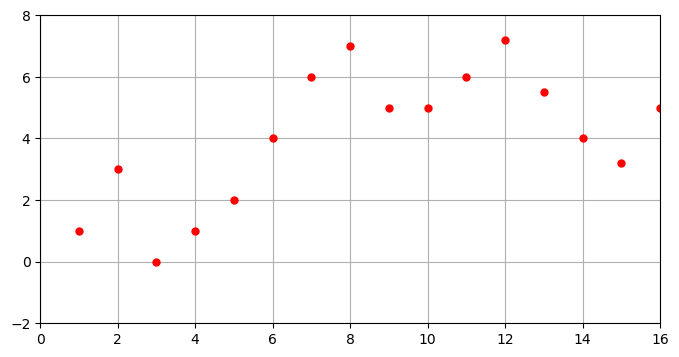

In [3]:
# define (x,y) coordinates of the points
x = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16 ]
y = [ 1, 3, 0, 1, 2, 4, 6, 7, 5, 5, 6, 7.2, 5.5,  4, 3.2, 5]

using PyPlot
figure(figsize=(8,4))
plot(x,y,"r.", markersize=10)
axis([0,16,-2,8])
grid("True")

In [4]:
# Fit the data using a function of the form y = f(x) = u1 x^k + u2 x^(k-1) + ... + uk x + u{k+1}

# Order of polynomial used for fitting
k = 4

# Create the A matrix (where each row corresponds to one observation x_i and each column is an x^k term)
n = length(x)
A = zeros(n,k+1)
for i = 1:n
    for j = 1:k+1
        A[i,j] = x[i]^(k+1-j)
    end
end

In [5]:
# NOTE: must have either Gurobi or Mosek installed!

# Solve the LEAST SQUARES polynomial fit

# using JuMP, Gurobi, MosekTools, Mosek
using JuMP, Gurobi

#m = Model(with_optimizer(Gurobi.Optimizer))
#m = Model(with_optimizer(Gurobi.Optimizer,OutputFlag=0))
#m = Model(with_optimizer(Gurobi.Optimizer,NumericFocus=3,BarHomogeneous=1))
#m = Model(with_optimizer(Mosek.Optimizer))
#m = Model(with_optimizer(Mosek.Optimizer,LOG=0))


# const GRB_ENV = Gurobi.Env()
# m = Model(() -> Gurobi.Optimizer(GRB_ENV))

m = Model(Gurobi.Optimizer)

@variable(m, u[1:k+1])
@objective(m, Min, sum( (y - A*u).^2 ) )
# @objective(m, Min, dot(y-A*u,y-A*u) )

optimize!(m)
uopt = value.(u)
println(termination_status(m))
println("The objective value is ", objective_value(m))
println("The optimal parameters are ",uopt)

[ Info: Precompiling Gurobi [2e9cd046-0924-5485-92f1-d5272153d98b]


Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-15
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 5 columns and 0 nonzeros
Model fingerprint: 0xc477cc36
Model has 15 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [1e+02, 2e+06]
  QObjective range [3e+01, 2e+10]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve time: 0.00s
Presolved: 0 rows, 5 columns, 0 nonzeros
Presolved model has 15 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 9
 AA' NZ     : 6.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective   

In [6]:
# Solve the L_1 NORM polynomial fit. 
# Note: We MUST use an LP solver for this! 
# When using the L_1 criterion, there is no equivalent of the normal equations or the backslash command.

# using JuMP, Gurobi, MosekTools, Mosek
using JuMP, Gurobi

m = Model(Gurobi.Optimizer)
#m = Model(with_optimizer(Mosek.Optimizer))

@variable(m, u[1:k+1])
@variable(m, t[1:n] >= 0)
@constraint(m, y-A*u .<= t)
@constraint(m, A*u-y .<= t)
@objective(m, Min, 1/1000*sum(t))

optimize!(m)
uopt_l1 = value.(u)
println(termination_status(m))
println(objective_value(m))
println(uopt_l1)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-15
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 32 rows, 21 columns and 192 nonzeros
Model fingerprint: 0x0fc9b0de
Coefficient statistics:
  Matrix range     [1e+00, 7e+04]
  Objective range  [1e-03, 1e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+00]
Presolve time: 0.00s
Presolved: 32 rows, 21 columns, 192 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      23    1.2167133e-02   0.000000e+00   0.000000e+00      0s

Solved in 23 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.216713287e-02

User-callback calls 65, time in user-callback 0.00 sec
OPTIMAL
0.012167132867132871
[0.003302253302253309, -0.11600621600621623, 1.27944832944833

In [7]:
# Compute the LEAST SQUARES fit directly from normal equations

uopt2=inv(A'*A)*(A'*y)
println(uopt2)
residual2=1/1000*sum((y-A*uopt2).^2)

[0.002320865086925322, -0.08461679037336248, 0.9697320046438656, -3.351588258447633, 4.320673076923054]


0.01716439226601571

In [8]:
# Compute the LEAST SQUARES fit from the backslash command

uopt3=A\y

5-element Vector{Float64}:
  0.002320865086925428
 -0.08461679037336833
  0.9697320046439526
 -3.3515882584477406
  4.3206730769230495

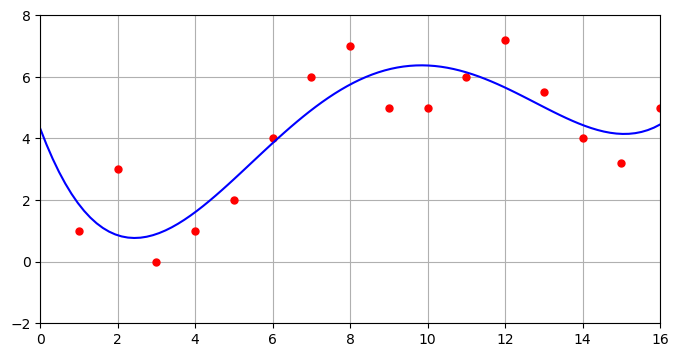

In [9]:
using PyPlot, LinearAlgebra
npts = 100
xfine = range(0,stop=16,length=npts)
ffine = ones(npts)
for j = 1:k
    ffine = [ffine.*xfine ones(npts)]
end
yfine = ffine * uopt
figure(figsize=(8,4))
plot( x, y, "r.", markersize=10)
plot( xfine, yfine, "b-")
axis([0,16,-2,8])
grid()

In [11]:
Pkg.add("ECOS")
Pkg.add("SCS")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [9]:
# NOTE: problem can be solved using ECOS or SCS if written as an "SOCP" --- more on this later!
# Here is a working example:

using JuMP, ECOS, SCS

m = Model(optimizer_with_attributes(SCS.Optimizer, "verbose" =>0))

@variable(m, u[1:k+1])
@variable(m, t)
@constraint(m, [t; y - A*u] in SecondOrderCone())
@objective(m, Min, t)

optimize!(m)
uopt = value.(u)
println(termination_status(m))
println(uopt)

OPTIMAL
[0.002320865086925143, -0.08461679037335854, 0.9697320046438421, -3.3515882584472863, 4.320673076922571]
